In [1]:
import os
import wandb
import copy 
import json
import pickle 

import pandas as pd 
print(pd.__version__)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import analyse_results_utils
from es_map import custom_configs
from es_map.my_brax_envs import brax_envs



1.4.2


In [ ]:
# First we load the plain ES results
# I have the metrics:
# - Best ever fitness
# - Best ever eval fitness
# - Best ever evolvability
# - QD
# - ED
# What I want from the ES runs:
# - Best ever eval fitness
# - best ever fitness
# - best ever evolvability (make sure we use the same bd descriptor)
# - QD ? Yes
# - ED ? No





In [2]:
# ES RUNS
api = wandb.Api()
jax_es_sweep = api.sweep("adam_katona/uncategorized/jd18zi1o") 
sweep_runs = list(jax_es_sweep.runs)
len(sweep_runs)

540

In [3]:
# Filter run
def interesting_run(config):
    if config["env_name"] == "humanoid" or config["env_name"] == "ant":
        if config["env_mode"] == "DISTANCE_FINAL_POS":
            if (config["ES_UPDATES_MODES_TO_USE"][0] == "fitness" or 
                config["ES_UPDATES_MODES_TO_USE"][0] == "evo_ent" or 
                config["ES_UPDATES_MODES_TO_USE"][0] == "quality_evo_ent" or 
                config["ES_UPDATES_MODES_TO_USE"][0] == "quality_evo_ent_innovation"):
                return True
    return False

interesting_runs = [wanddb_run for wanddb_run in sweep_runs if interesting_run(wanddb_run.config)]
len(interesting_runs)

16

In [5]:
all_runs = []
failed_runs = []
for i,wanddb_run in enumerate(interesting_runs):
    run_logs = wanddb_run.history()
    if len(run_logs) == 0:
        failed_runs.append(wanddb_run.config)
    else:
        run = {
            "wandb_run" : wanddb_run,
            "run_logs" : run_logs,
            "config" : wanddb_run.config,
        }
        all_runs.append(run)
print("all_runs ",len(all_runs))
print("failed_runs ",len(failed_runs))

all_runs  16
failed_runs  0


In [25]:
for run in all_runs:
    run["best_eval_fitness"] = np.max(run["run_logs"]["eval_mean_dist"])
    run["best_fitness"] = np.max(run["run_logs"]["max_dist"])
    run["best_evo_ent"] = np.max(run["run_logs"]["evo_ent"])
    run["best_evo_var"] = np.max(run["run_logs"]["evo_var"])
    
    if run["config"]["ES_UPDATES_MODES_TO_USE"][0] == "fitness":
        run["algo_name"] = "ES"
    elif run["config"]["ES_UPDATES_MODES_TO_USE"][0] == "evo_ent":
        run["algo_name"] = "E-ES"
    elif run["config"]["ES_UPDATES_MODES_TO_USE"][0] == "quality_evo_ent":
        run["algo_name"] = "QE-ES"
    elif run["config"]["ES_UPDATES_MODES_TO_USE"][0] == "quality_evo_ent_innovation":
        run["algo_name"] = "QDE-ES"
    else:
        raise "OOOO"
    
    # QD
    run["QD"] = np.max(run["run_logs"]["pos_qd_score"])
    run["QD_CUMM"] = np.max(run["run_logs"]["pos_cumm_qd_score"])
    
    # ED
    # no ED
    
    
    

In [28]:
ES_grouped_runs = {
    "ant" : {},
    "humanoid" : {}
}
def get_results_from_run(run):
    return {
        "best_eval_fitness" : run["best_eval_fitness"],
        "best_fitness" : run["best_fitness"],
        "best_evo_ent" : run["best_evo_ent"],
        "best_evo_var" : run["best_evo_var"],
        "QD" : run["QD"],
        "QD_CUMM" : run["QD_CUMM"],
    }
for run in all_runs:
    algo_name = run["algo_name"]
    env_name = run["config"]["env_name"]
    if algo_name not in ES_grouped_runs[env_name]:
        ES_grouped_runs[env_name][algo_name] = []
    ES_grouped_runs[env_name][algo_name].append(get_results_from_run(run))

In [41]:
import pickle
#with open('ES_grouped_runs.pickle', 'wb') as handle:
#    pickle.dump(ES_grouped_runs, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [29]:
api = wandb.Api()

# I have 2 sets of ablation runs
# khbnp2ax, with this one, we only use the noramlisation of the first gen
# nookzh93, with this one, we use original norm, but halfway we changed the code to do first gen only
jax_es_sweep = api.sweep("adam_katona/uncategorized/khbnp2ax")
jax_es_sweep_2 = api.sweep("adam_katona/uncategorized/nookzh93")
sweep_runs = list(jax_es_sweep.runs)
sweep_runs.extend(list(jax_es_sweep_2.runs))
len(sweep_runs)

150

In [30]:
def id_to_path(id):
    from glob import glob    
    glob_res = glob("/scratch/ak1774/runs/large_files_jax/*"+id, recursive = False)
    if len(glob_res) > 0:
        return glob_res[0]
    return None

In [31]:
all_runs = []
failed_runs = []
for i,wanddb_run in enumerate(sweep_runs):
    if i%40 == 0:
        print(i,"/",len(sweep_runs))
    #run_logs = wanddb_run.history()
    
    config = copy.deepcopy(wanddb_run.config)
    config = custom_configs.get_config_from_index(config,config["config_index"])
    bd_descriptor = brax_envs.env_to_bd_descriptor(config["env_name"],config["env_mode"])
    config["map_elites_grid_description"] = bd_descriptor
    
    
    run_id = wanddb_run.dir.split("/")[-1]
    run = {}
    run["path"] = id_to_path(run_id)
    if run["path"] is None:
        failed_runs.append(wanddb_run.config)
        continue
    if  os.path.exists(run["path"]+"/b_archive.npy"):
        run["b_map_evolver"] = np.load(run["path"]+"/b_map_evolver.npy",allow_pickle=True)
        run["b_map_performance"] = np.load(run["path"]+"/b_map_performance.npy",allow_pickle=True)
        run["b_archive"] = np.load(run["path"]+"/b_archive.npy")
        with open(run["path"] + '/all_step_logs.pickle', 'rb') as handle:
            logs = pickle.load(handle)
        run["logs"] = logs
        run["wandb_run"] = wanddb_run
        run["config"] = config
        run["config_name"] = config["config_name"]
        all_runs.append(run)
    else:
        failed_runs.append(wanddb_run.config)

0 / 150
40 / 150
80 / 150
120 / 150


In [32]:
print("all_runs: ",len(all_runs))
print("failed_runs: ",len(failed_runs))

all_runs:  135
failed_runs:  15


In [36]:
# Metrics
# - Best ever fitness
# - Best ever eval fitness
# - Best ever evolvability
# - QD
# - ED

logs_to_plot = [
    "best_ever_eval_distance_walked",
    "best_ever_child_mean_distance_walked",
    "best_ever_child_distance_walked",
    #"evolver_ed_var_score",
    "evolver_ed_ent_score",
    "perf_qd_mean_dist",
]
# let us create the data we are interested in
envs = ["ant","humanoid"]

env_result_data = {}
for env in envs:
    env_result_data[env] = {}
    for run in all_runs:
        if run["config"]["env_name"] == env:
            if run["config"]["config_name"] not in env_result_data[env]:
                env_result_data[env][run["config"]["config_name"]] = []
                
                
            run_results = {}
            for metric in logs_to_plot:
                run_results[metric] = run["logs"][-1][metric]
            run_results["evo_ent"] = np.max([log["evo_ent"] for log in run["logs"]])
            run_results["evo_var"] = np.max([log["evo_var"] for log in run["logs"]])
                
            env_result_data[env][run["config"]["config_name"]].append(run_results)
            

metrics =  copy.copy(logs_to_plot)  
metrics.append("evo_ent")
metrics.append("evo_var")

In [43]:
#with open('env_result_data.pickle', 'wb') as handle:
#    pickle.dump(env_result_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [37]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [6, 5]

In [38]:
# ORDER
# ES baselines
# ES
# E-ES
# QE-ES

# ME baselines
# ME exploit
# ME explore-exploit

# ME explore-exploit-evolvability  (eval fitness)
# ME explore-exploit-evolvability  (excpected fitness)
# 

# ME-MM 
# E-ME-ND
# E-ME-



def plot_metric(metric_name,algo_order,env_result_data):
    for env_i,(env_name,env_results) in enumerate(env_result_data.items()):
        names = []
        values = []
        
        for config_name,results in env_results.items():
            names.append(config_name)
            values.append([res[metric_name] for res in results])
        
        # algo_order is an orderd dict -> config_name : algo_name
        ordered_vals = []
        ordered_names = []
        for config_name,algo_name in algo_order.items():
            i = names.index(config_name)
            ordered_vals.append(values[i])
            ordered_names.append(algo_name)
            
        sns.boxplot(data=ordered_vals,color="white",saturation=0)#,whis=(0,100))
        sns.stripplot(data=ordered_vals)#,color="black")
        plt.xticks(list(range(len(ordered_names))),ordered_names,rotation = 90)
        plt.ylabel(metric_name)
        plt.title(env_name+" "+metric_name)
        #plt.ylim(bottom=0)
        
        plt.show()
    
    
    
def plot_metric_with_es(metric_name,env_result_data,es_results):
    pass

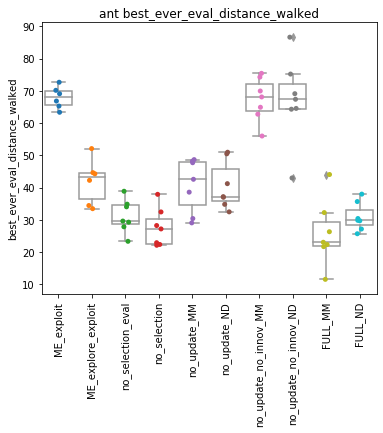

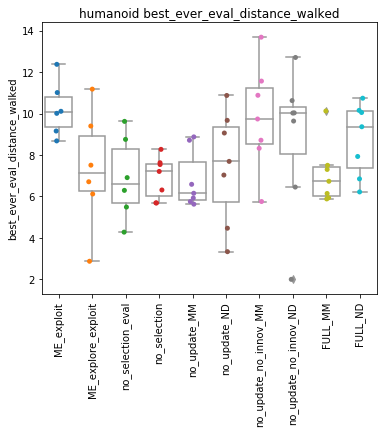

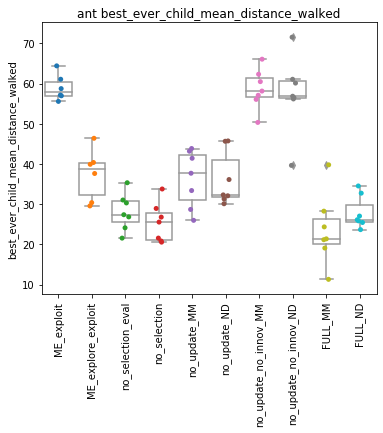

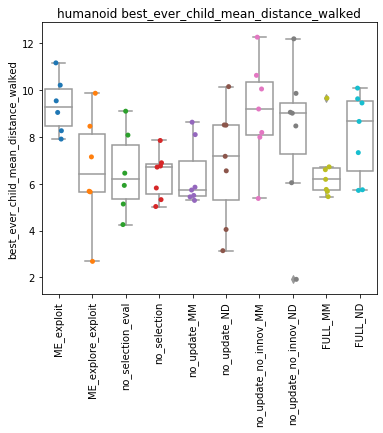

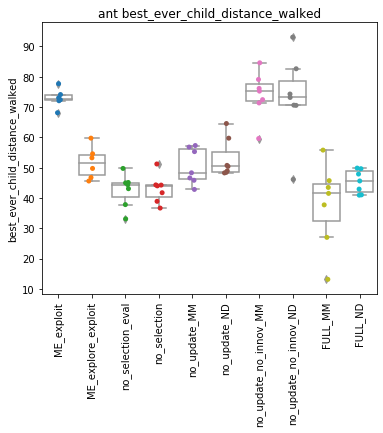

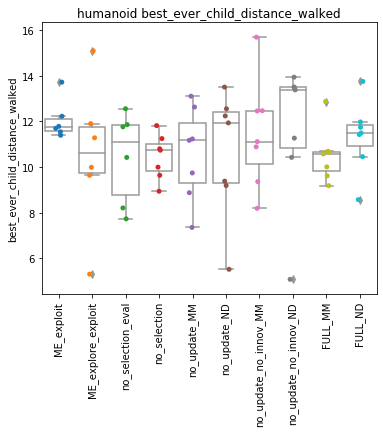

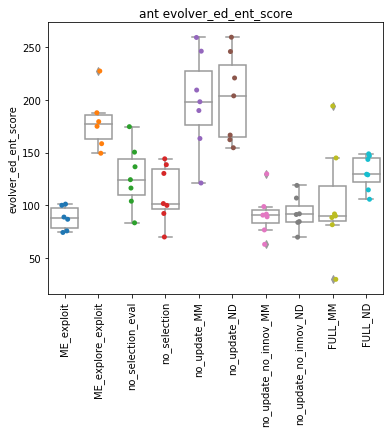

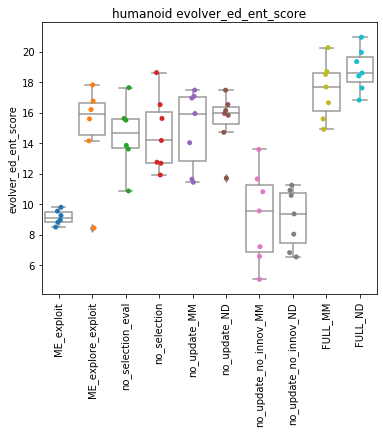

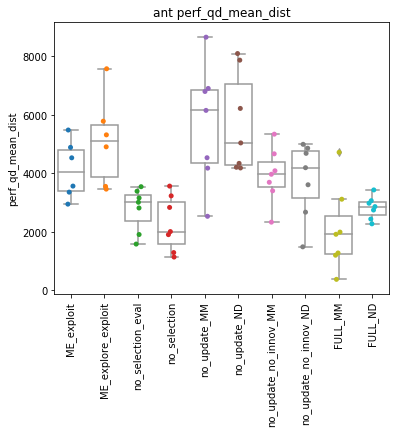

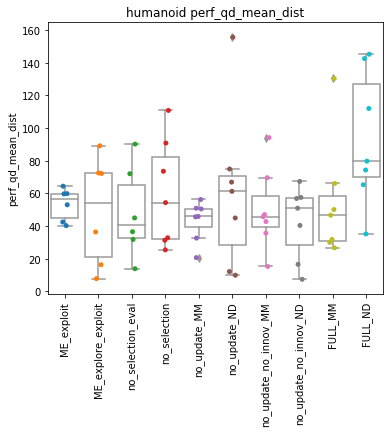

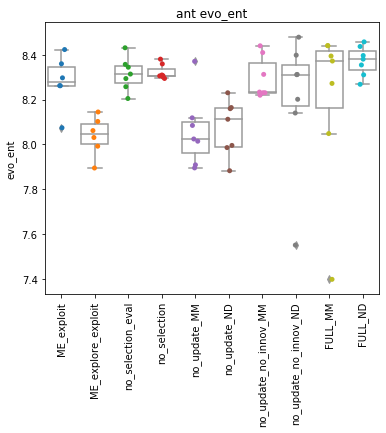

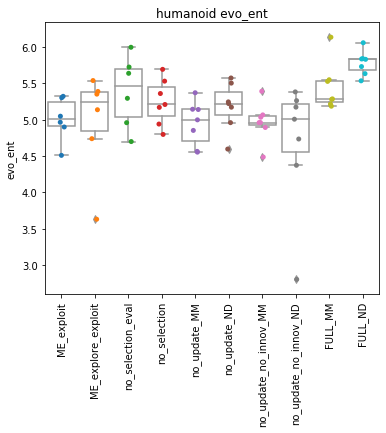

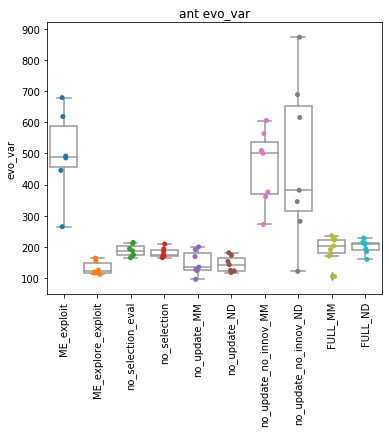

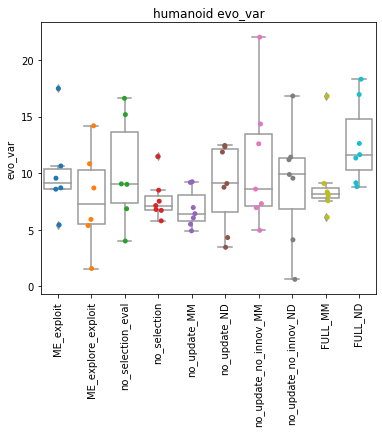

In [40]:
algo_order = {
    "NO_BOTH_ME__exploit" : "ME_exploit",
    "NO_BOTH_ME__explore-exploit" : "ME_explore_exploit",
    "NO_EVOLVABILITY_SELECTION_EVAL_FITNESS" : "no_selection_eval",
    "NO_EVOLVABILITY_SELECTION" : "no_selection",
    "NO_EVOLVABILITY_UPDATE_MM" : "no_update_MM",
    "NO_EVOLVABILITY_UPDATE_ND" : "no_update_ND",
    "NO_EVOLVABILITY_UPDATE_NO_INNOV_MM" : "no_update_no_innov_MM",
    "NO_EVOLVABILITY_UPDATE_NO_INNOV_ND" : "no_update_no_innov_ND",
    "FULL_MM" : "FULL_MM",
    "FULL_ND" : "FULL_ND",
}

for metric in metrics:
    plot_metric(metric,algo_order,env_result_data)

ant
humanoid


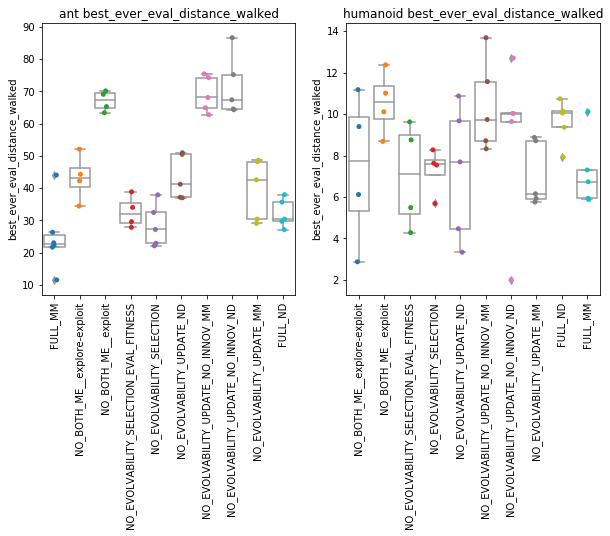

ant
humanoid


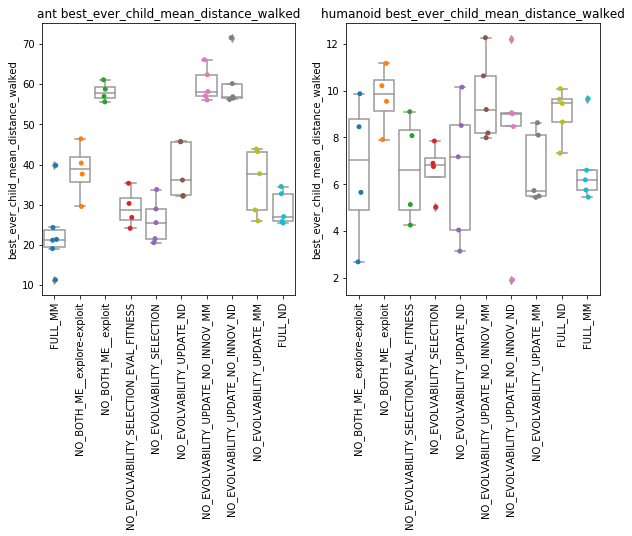

ant
humanoid


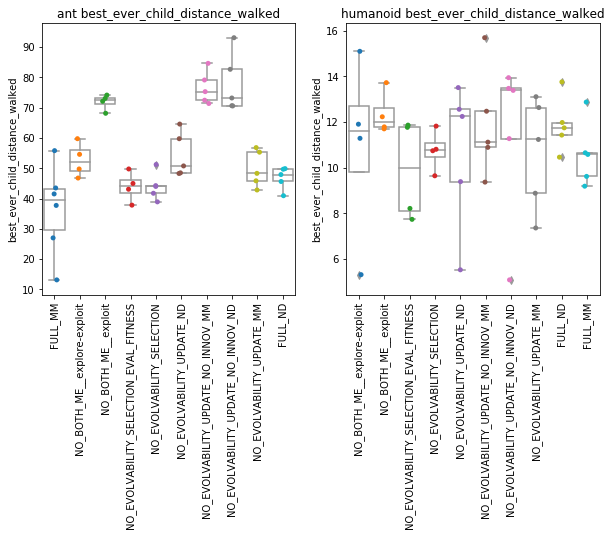

ant
humanoid


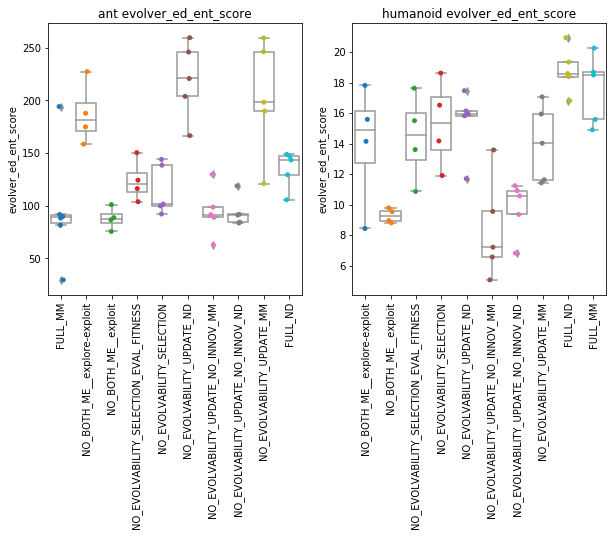

ant
humanoid


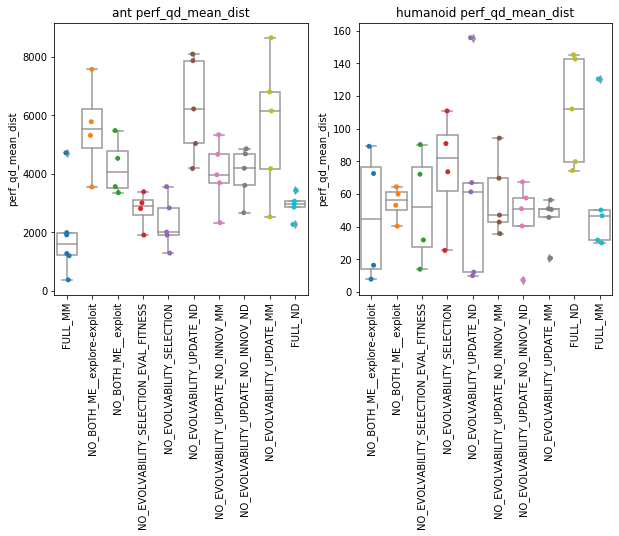

ant
humanoid


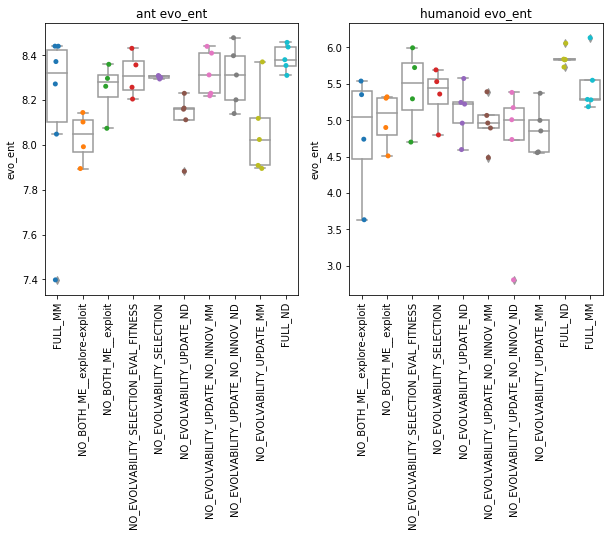

ant
humanoid


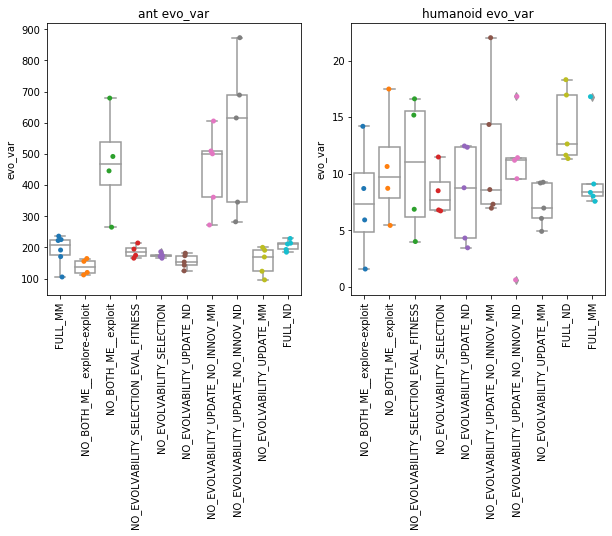

In [11]:


for metric in metrics:
    for env_i,(env_name,env_results) in enumerate(env_result_data.items()):
        print(env_name)
        names = []
        values = []
        for config_name,results in env_results.items():
            names.append(config_name)
            values.append([res[metric] for res in results])
            
        #plt.subplot(1, 2, env_i+1)
        sns.boxplot(data=values,color="white",saturation=0)#,whis=(0,100))
        sns.stripplot(data=values)#,color="black")
        plt.xticks(list(range(len(names))),names,rotation = 90)
        plt.ylabel(metric)
        plt.title(env_name+" "+metric)
        #plt.ylim(bottom=0)
        
        plt.show()

ant


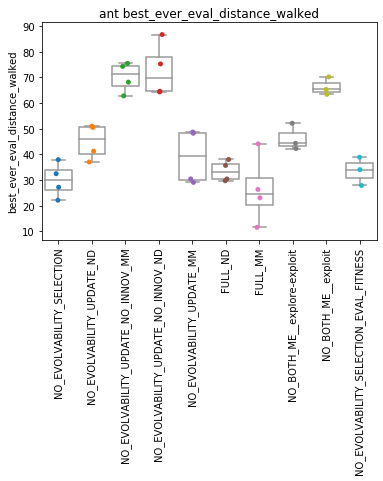

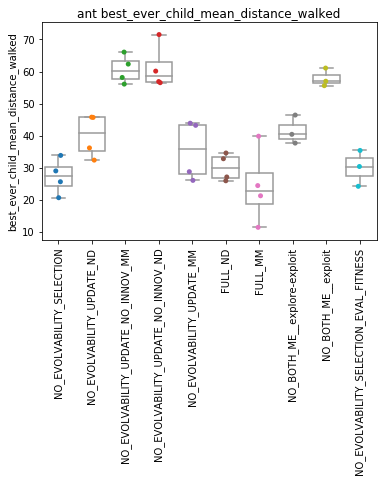

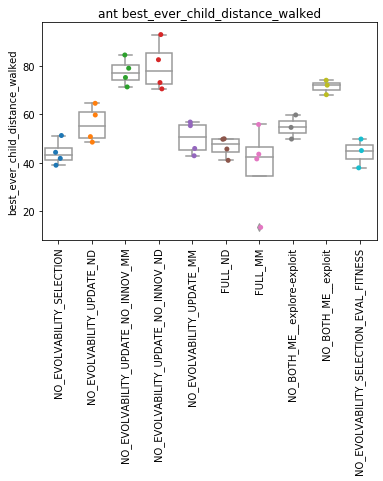

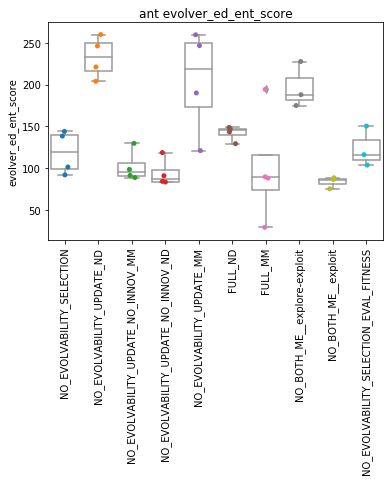

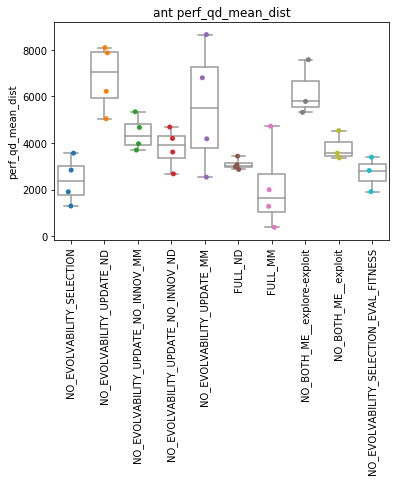

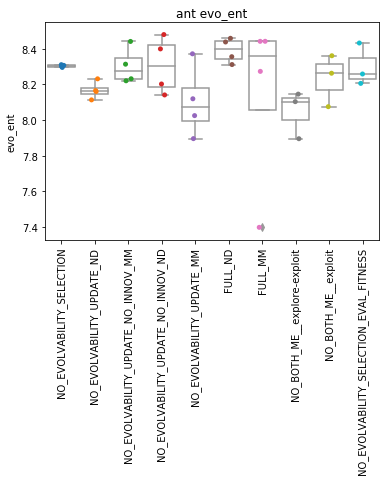

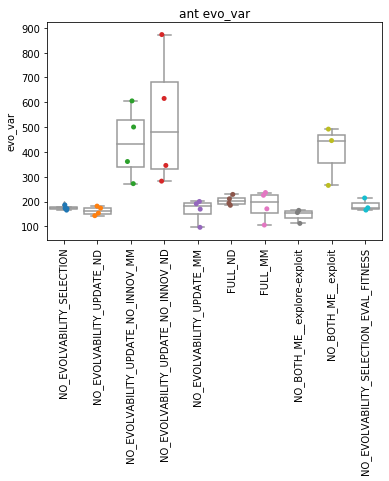

humanoid


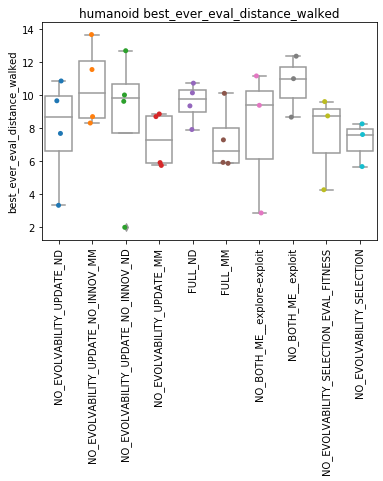

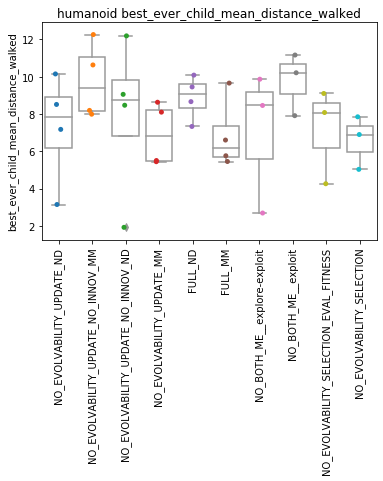

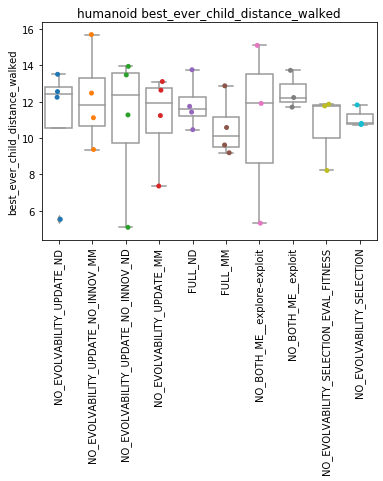

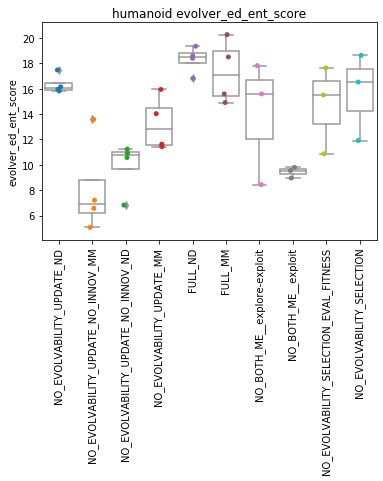

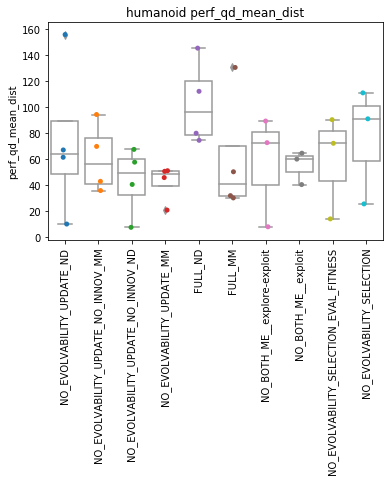

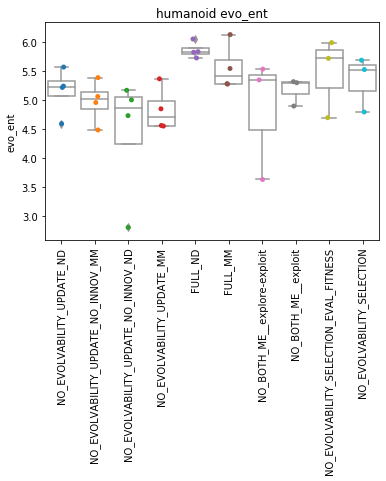

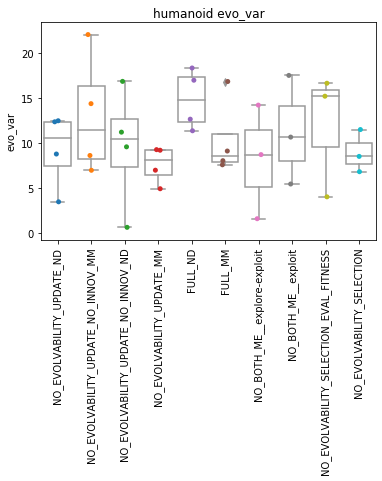

In [9]:
# Plots of big run